# Installs & Imports

In [1]:
!pip install -q pmdarima

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from xgboost import XGBRegressor

# ARIMA-XGBoost Model

In [3]:
class HybridARIMAXGBoost:
    def __init__(
        self,
        arima_kwargs=None,
        xgb_kwargs=None,
        include_fourier=False,
        fourier_order=3,
        period=12,
        include_lag_features=False,
        lag_order=3
    ):
        """
        Initializes the hybrid model.

        Parameters:
          arima_kwargs (dict): Keyword arguments for auto_arima.
          xgb_kwargs (dict): Keyword arguments for XGBRegressor.
          include_fourier (bool): Whether to add Fourier features.
          fourier_order (int): Order of Fourier terms.
          period (int): Seasonal period (e.g., 12 for monthly data).
          include_lag_features (bool): Whether to add lagged residual features.
          lag_order (int): Number of lagged residuals to use.
        """
        if arima_kwargs is None:
            arima_kwargs = {
                'seasonal': True,
                'm': period,
                'trace': False,
                'error_action': 'ignore',
                'suppress_warnings': True
            }
        if xgb_kwargs is None:
            xgb_kwargs = {
                'max_depth': 20,
                'learning_rate': 0.1,
                'n_estimators': 200,
                'random_state': 42
            }
        self.arima_kwargs = arima_kwargs
        self.xgb_kwargs = xgb_kwargs
        self.include_fourier = include_fourier
        self.fourier_order = fourier_order
        self.period = period
        self.include_lag_features = include_lag_features
        self.lag_order = lag_order

        self.arima_model = None
        self.xgb_model = None
        self.last_index = None  # length of the training series
        self.last_lags = None
        self.train_residuals = None

    def _build_features_train(self, residuals):
        """
        Build the feature matrix for training XGBoost on residuals.
        Features include: time index, optional Fourier terms, and optional lagged residuals.
        """
        n = len(residuals)
        features = []
        for i in range(n):
            row = [i]  # time index
            if self.include_fourier:
                for k in range(1, self.fourier_order + 1):
                    row.append(np.sin(2 * np.pi * k * i / self.period))
                    row.append(np.cos(2 * np.pi * k * i / self.period))
            if self.include_lag_features:
                for lag in range(1, self.lag_order + 1):
                    if i - lag >= 0:
                        row.append(residuals[i - lag])
                    else:
                        row.append(0.0)
            features.append(row)
        return np.array(features)

    def _build_features_forecast(self, t_val, lag_vector=None):
        """
        Build a feature vector for forecasting at time t_val.
        """
        row = [t_val]
        if self.include_fourier:
            for k in range(1, self.fourier_order + 1):
                row.append(np.sin(2 * np.pi * k * t_val / self.period))
                row.append(np.cos(2 * np.pi * k * t_val / self.period))
        if self.include_lag_features:
            if lag_vector is not None:
                row.extend(lag_vector)
            else:
                row.extend([0.0] * self.lag_order)
        return np.array(row)

    def fit(self, y):
        """
        Fit the hybrid model on the training time series (pandas Series).
        """
        # Fit ARIMA on training data
        self.arima_model = auto_arima(y, **self.arima_kwargs)
        arima_fitted = self.arima_model.predict_in_sample()
        residuals = y - arima_fitted
        self.train_residuals = residuals.values

        # Build features and fit XGBoost on residuals
        X_train_features = self._build_features_train(self.train_residuals)
        self.xgb_model = XGBRegressor(**self.xgb_kwargs)
        self.xgb_model.fit(X_train_features, self.train_residuals)
        self.last_index = len(y)

        if self.include_lag_features:
            last_vals = []
            for lag in range(1, self.lag_order + 1):
                if self.last_index - lag >= 0:
                    last_vals.append(self.train_residuals[self.last_index - lag])
                else:
                    last_vals.append(0.0)
            self.last_lags = last_vals
        return self

    def predict(self, n_periods):
        """
        Forecast the next n_periods.
        The final forecast is the sum of the ARIMA forecast and the XGBoost residual correction.
        """
        arima_forecast = self.arima_model.predict(n_periods=n_periods)
        forecast_residuals = []
        if self.include_lag_features:
            current_lags = self.last_lags.copy()
            for i in range(n_periods):
                t_val = self.last_index + i
                x_feat = self._build_features_forecast(t_val, lag_vector=current_lags)
                pred_res = self.xgb_model.predict(x_feat.reshape(1, -1))[0]
                forecast_residuals.append(pred_res)
                current_lags = [pred_res] + current_lags[:-1]
            forecast_residuals = np.array(forecast_residuals)
        else:
            X_forecast = []
            for i in range(n_periods):
                t_val = self.last_index + i
                x_feat = self._build_features_forecast(t_val)
                X_forecast.append(x_feat)
            X_forecast = np.array(X_forecast)
            forecast_residuals = self.xgb_model.predict(X_forecast)

        final_forecast = arima_forecast + forecast_residuals
        return final_forecast

# Data Loading

In [4]:
# Load the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
y = data['Passengers']

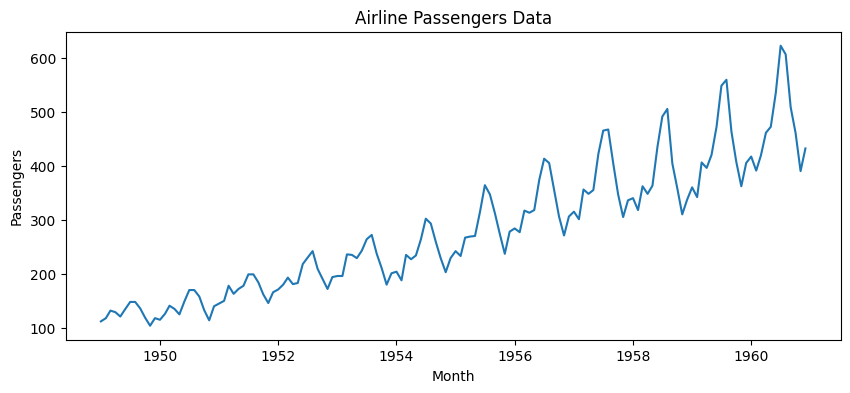

In [5]:
# Plot the data
plt.figure(figsize=(10, 4))
plt.plot(y)
plt.title('Airline Passengers Data')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.show()

# Data Preparation

In [6]:
# Define a train/test split (e.g., last 24 months as test)
test_size = 24
train_size = int(len(y) - test_size)
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

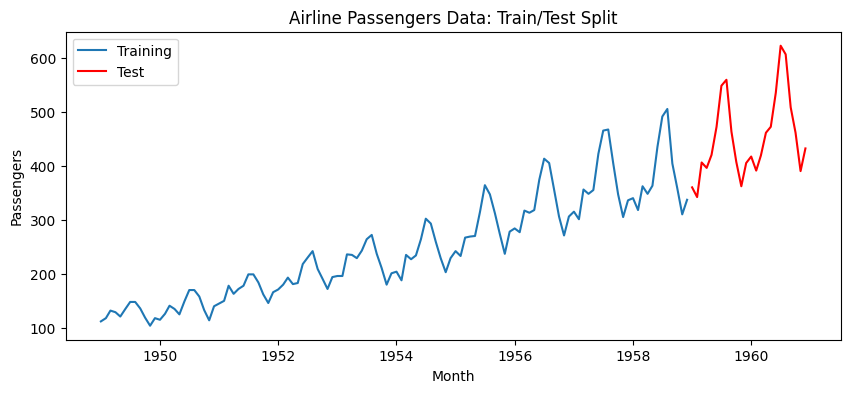

In [7]:
# Plot the training and test sets
plt.figure(figsize=(10, 4))
plt.plot(y_train, label='Training')
plt.plot(y_test, label='Test', color='red')
plt.title('Airline Passengers Data: Train/Test Split')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.legend()
plt.show()

In [8]:
# Log transformation
y_train_log_np = np.log(y_train)
y_test_log_np = np.log(y_test)

# Convert to Series
y_train_log = pd.Series(y_train_log_np, index=y_train.index)
y_test_log = pd.Series(y_test_log_np, index=y_test.index)

# Model Fitting

In [9]:
from sklearn.utils import validation

# Monkey-patching deprecated 'force_all_finite' to new 'ensure_all_finite'
# Only patch if not already patched
if not hasattr(validation.check_array, '_original'):
    # Save a reference to the original function
    original_check_array = validation.check_array

    def patched_check_array(*args, **kwargs):
        # Remap the old parameter name to the new one if provided
        if 'force_all_finite' in kwargs:
            kwargs['ensure_all_finite'] = kwargs.pop('force_all_finite')
        return patched_check_array._original(*args, **kwargs)

    # Store the original function in an attribute
    patched_check_array._original = original_check_array

    # Mark the function as patched
    patched_check_array._monkey_patched = True

    # Replace the original function with the patched version
    validation.check_array = patched_check_array

In [10]:
# Fit the hybrid model
model = HybridARIMAXGBoost(
    include_fourier=True,
    fourier_order=3,
    include_lag_features=True,
    lag_order=3,
    arima_kwargs={
        'seasonal': True,
        'm': 12,
        'trace': False,
        'error_action': 'ignore',
        'suppress_warnings': True
    },
    xgb_kwargs={
        'max_depth': 20,
        'learning_rate': 0.05,
        'n_estimators': 200,
        'random_state': 42
    }
)
model.fit(y_train_log)

# Model Forecasting

In [11]:
# Forecast for the test period (24 months)
n_forecast = len(y_test)
forecast_log_scale = model.predict(n_forecast)
forecast = np.exp(forecast_log_scale)

In [12]:
# Evaluate forecast performance
mse = np.mean((y_test - forecast) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test - forecast))
mape = np.mean(np.abs((y_test - forecast) / y_test)) * 100
smape = np.mean(np.abs(y_test - forecast) / (np.abs(y_test) + np.abs(forecast))) * 200

# Create metrics DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'MAPE', 'SMAPE'],
    'Value': [mse, rmse, mae, mape, smape]
})
display(metrics_df)

,Metric,Value
0,MSE,303.709832
1,RMSE,17.427273
2,MAE,14.684839
3,MAPE,3.385304
4,SMAPE,3.445349


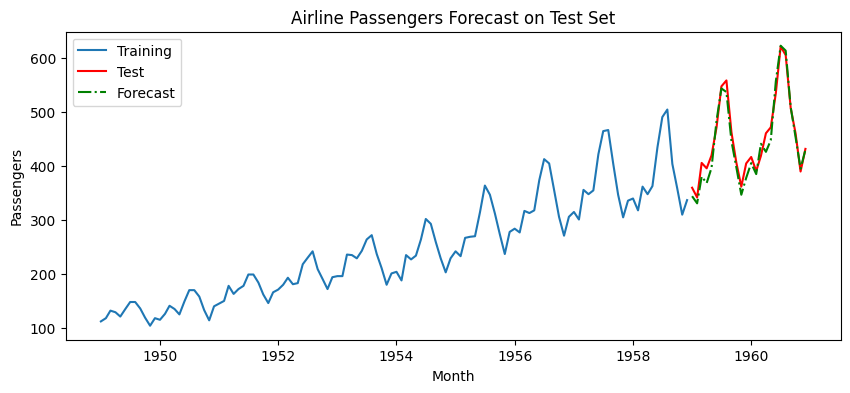

In [13]:
# Build forecast DataFrame
last_date = y_train.index[-1]
forecast_index = pd.date_range(last_date, periods=n_forecast+1, freq='MS')[1:]
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecast'])

# Plot the forecast vs. actual test values
plt.figure(figsize=(10, 4))
plt.plot(y_train, label='Training')
plt.plot(y_test, label='Test', color='red')
plt.plot(forecast_df, label='Forecast', color='green', linestyle="-.")
plt.title('Airline Passengers Forecast on Test Set')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.legend()
plt.show()